# Server-Side Coexpression Analysis

This notebook demonstrates how to use the Malva coexpression API to identify
correlated genes, visualise metacell UMAP projections, and explore GO
enrichment — all computed server-side without needing scanpy locally.

## 1. Setup

Connect to the Malva API. If you have configured your token via
`malva_client config`, no arguments are needed.

In [ ]:
API_TOKEN = "" # <- put your token here

In [2]:
from malva_client import MalvaClient

client = MalvaClient("https://malva.mdc-berlin.de", API_TOKEN)

INFO:malva_client.client:Connected to Malva API: healthy
INFO:malva_client.client:Authenticated successfully: free account


## 2. Discover Datasets

Browse the dataset hierarchy to find a dataset ID for coexpression analysis.

In [3]:
hierarchy = client.get_datasets_hierarchy()
client.print_dict_summary(hierarchy)

datasets: [{'cell_count': 52391470.0, 'dataset_id': 'default', 'description': 'All available samples', 'kmer_size': 64, 'name': 'Default Dataset', 'organism': 'Multiple', 'restricted': False, 'studies': [{'diseases': ['systemic lupus erythematosus'], 'laboratory': 'Unknown', 'organisms': ['Homo sapiens'], 'organs': ['blood'], 'sample_count': 269, 'study_name': 'Single-cellRNA-seqrevealscelltype-specificmolecula', 'study_title': 'Single-cell RNA-seq reveals cell type-specific molecular and genetic associations to lupus', 'total_cells': 5980942.0}, {'diseases': ['Lewy body dementia', 'Parkinson disease', 'dementia', 'normal'], 'laboratory': 'Genetics and Genomic Sciences', 'organisms': ['Homo sapiens'], 'organs': ['brain'], 'sample_count': 355, 'study_name': 'AtlasOfSubstantiaNigraInPD', 'study_title': "Single-Cell Transcriptomics of Human Substantia Nigra in Parkinson's Disease", 'total_cells': 4943983.0}, {'diseases': ['normal'], 'laboratory': 'Unknown', 'organisms': ['Homo sapiens'], 

## 3. Load UMAP Coordinates

Fetch the base UMAP embedding for a dataset. Replace `"DATASET_ID"`
with a dataset from the hierarchy above.

In [4]:
DATASET_ID = "Human_Cell_Atlas"

umap = client.get_umap_coordinates(DATASET_ID)
umap.to_dataframe().head()

,x,y,metacell_id,n_cells,sample,cluster
0,5.019366,5.303446,0,4,00238629-699e-404e-b59c-3cc998977dab,Muscle
1,4.458183,4.992155,1,3,00238629-699e-404e-b59c-3cc998977dab,Muscle
2,4.259455,6.150664,2,2,00238629-699e-404e-b59c-3cc998977dab,Muscle
3,3.423040,0.688364,3,56,00aa6c53-71b5-4c12-98c4-54eb8173ffa5,Endothelial
4,4.574430,0.048661,4,42,00aa6c53-71b5-4c12-98c4-54eb8173ffa5,Mesenchymal_Stromal (Fibroblast)


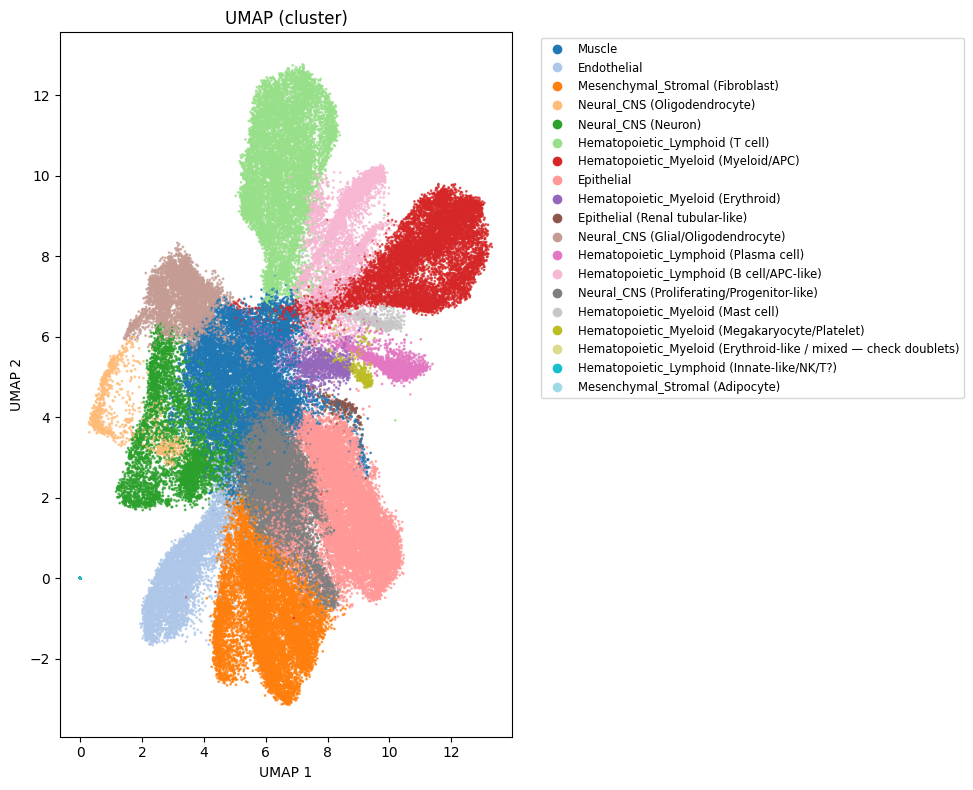

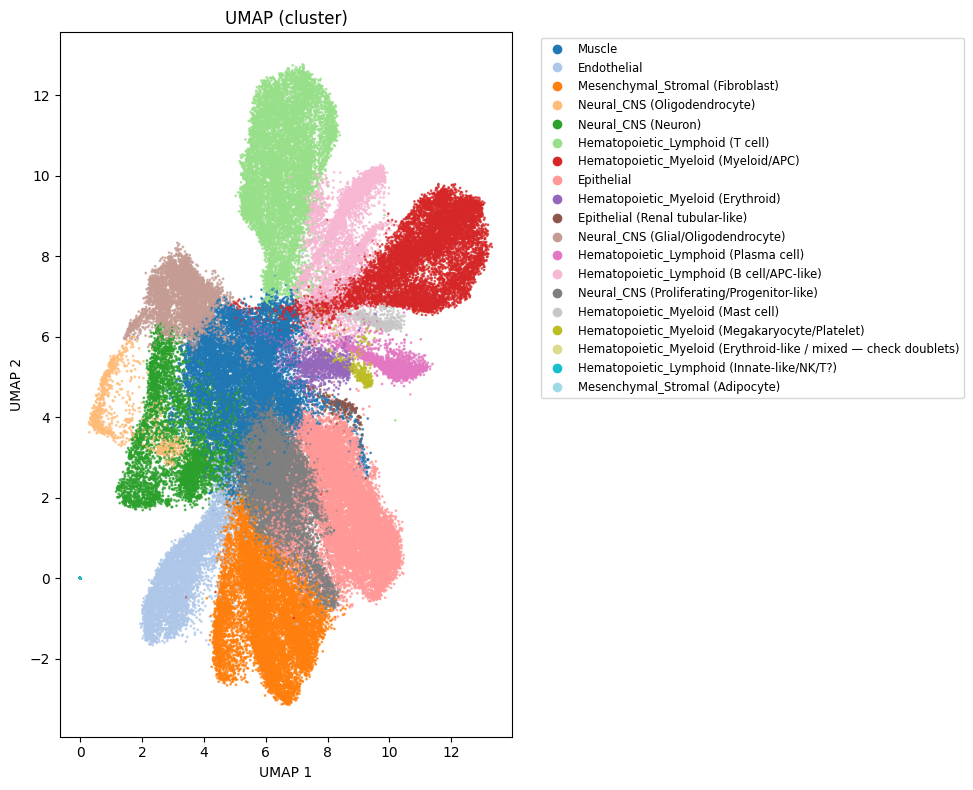

In [5]:
umap.plot(color_by='cluster')

## 4. Search for a Gene

Run a standard gene search and inspect the result.

In [6]:
result = client.search("FOXP3")
print(result)

INFO:malva_client.client:Search completed with job ID: 0df2d69e-1ddb-452a-87ce-041a4d09e19a


🔬 Malva Search Results
📊 Total cells: 53,582
📊 Sample/cell_type combinations: 12209
🧬 Genes/sequences: 1
🧪 Samples: 4324
🔬 Cell types: 241
📈 Expression range: 0.002 - 6.704
📊 Mean expression: 0.858

ℹ️  Basic expression data only
💡 Run .enrich_with_metadata() to add sample metadata for filtering by:
   • Organ, disease, species
   • Study, laboratory, protocol
   • Age, sex, development stage

🔍 Available methods:
   • .filter_by(organ='brain', disease='normal')
   • .aggregate_by('cell_type')
   • .plot_expression_by('organ')
   • .available_filter_fields()


## 5. Run Coexpression Analysis

Pass the search job ID and dataset to the coexpression API. This returns
correlated genes, UMAP scores, GO enrichment, cell-type enrichment, and
tissue breakdown — all computed on the server.

In [7]:
coexpr = client.get_coexpression(result.job_id, DATASET_ID)
print(coexpr)

CoexpressionResult(dataset='Human_Cell_Atlas', genes=100, query_cells=53552, metacells=13324, go_terms=141)


## 6. UMAP with Expression Scores

Colour the UMAP by the fraction of cells expressing the queried gene.

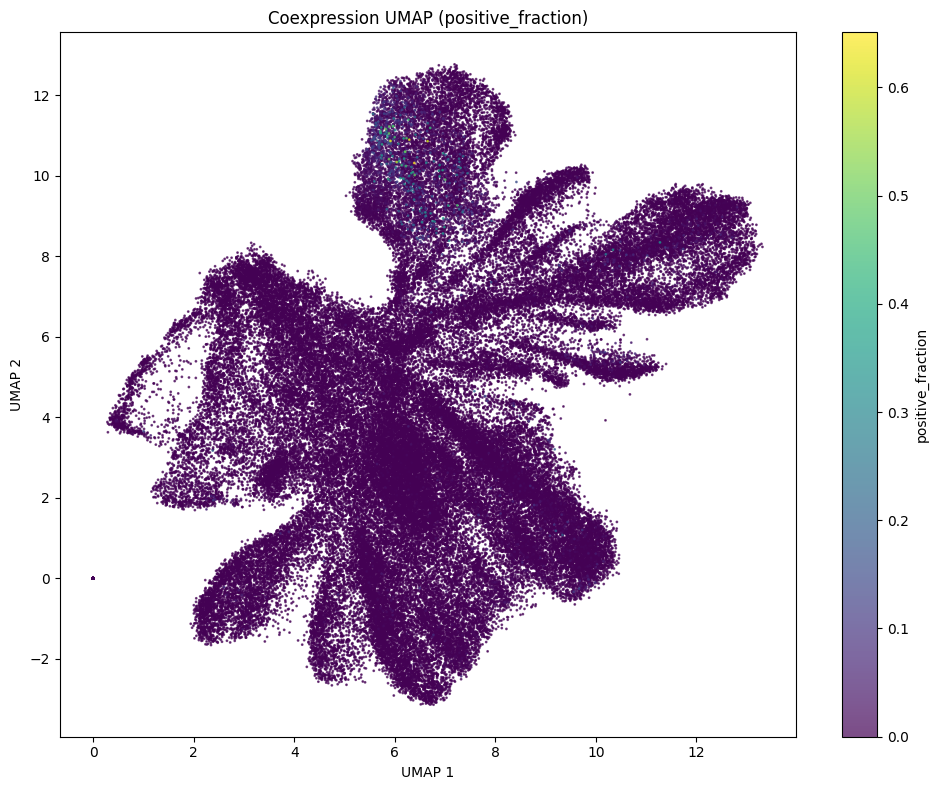

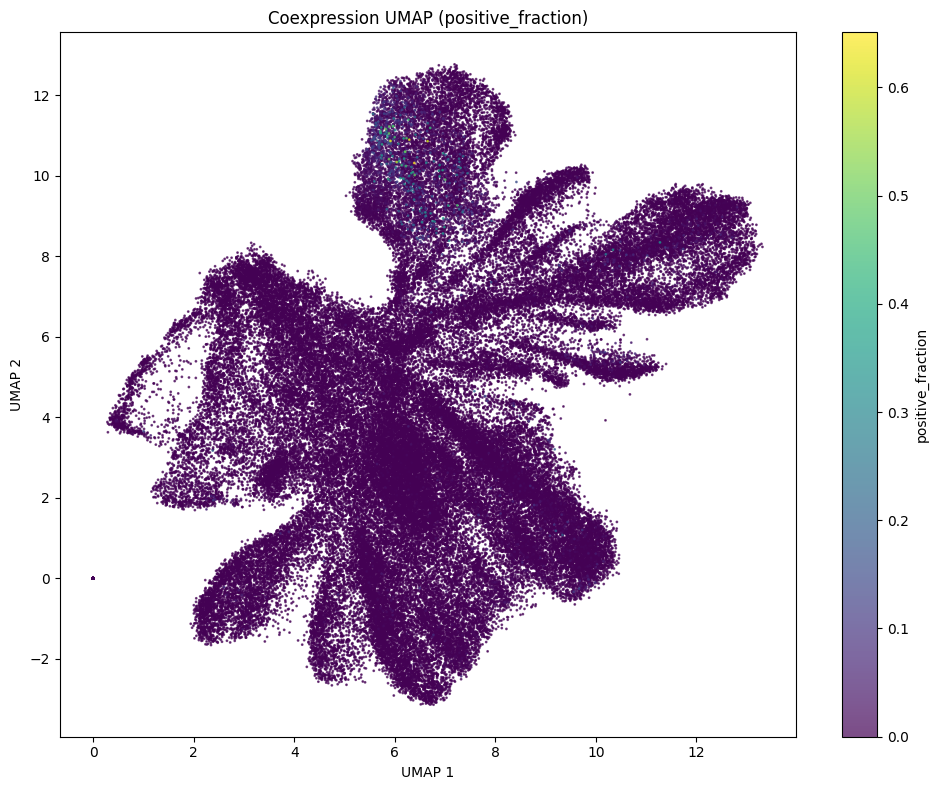

In [8]:
coexpr.plot_umap(color_by='positive_fraction')

## 7. Correlated Genes

Inspect the most strongly correlated genes.

In [9]:
genes_df = coexpr.genes_to_dataframe()
genes_df.head(20)

,correlation,gene,p_value
0,0.871105,FOXP3,0.0
1,0.575988,CTLA4,0.0
2,0.467397,IL2RA,0.0
3,0.447490,ICOS,0.0
4,0.426465,TIGIT,0.0
5,0.367793,CD5,0.0
6,0.366595,CD28,0.0
7,0.359007,TNFRSF4,0.0
8,0.340103,TNFRSF9,0.0
9,0.335349,BATF,0.0


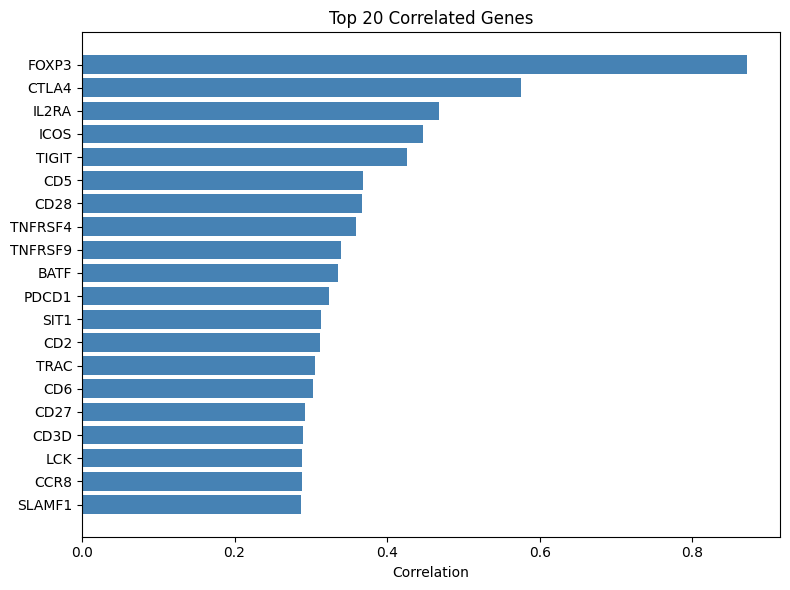

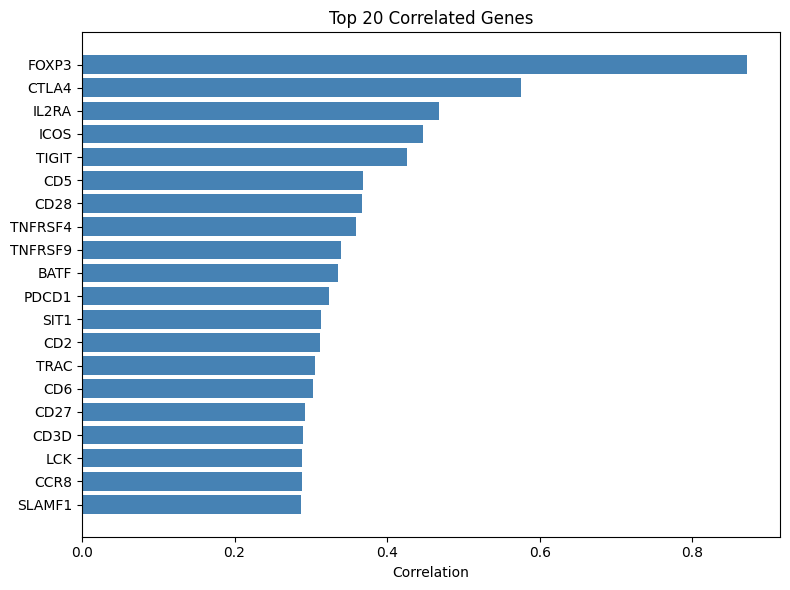

In [10]:
coexpr.plot_top_genes(n=20)

## 8. GO Enrichment

Explore Gene Ontology enrichment for the correlated gene set.

In [11]:
go_df = coexpr.go_to_dataframe()
go_df.head(10)

,fdr,genes,go_id,n_genes_in_term,name,namespace,p_value,query_genes_in_term
0,1.258759e-15,"[CCR4, CCR5, CCR6, CCR7, CCR8, CD2, CD7, CD96,...",GO:0006955,206,immune response,biological_process,4.325631e-18,29
1,3.266497e-14,"[CCR4, CCR5, CCR6, CCR7, CCR8, CD2, CD27, CD28...",GO:0009897,182,external side of plasma membrane,cellular_component,2.245015e-16,26
2,6.759542e-14,"[CD247, CD28, CD3D, CD3E, CD3G, CTLA4, FYB1, F...",GO:0050852,52,T cell receptor signaling pathway,biological_process,6.968600e-16,16
3,3.161380e-12,"[CASP8, CD2, CD27, CD28, CD3E, CD3G, CD7, CD70...",GO:0042110,45,T cell activation,biological_process,4.345539e-14,14
4,1.072697e-11,"[BIRC3, CCR5, CD2, CD247, CD27, CD28, CD3D, CD...",GO:0007166,128,cell surface receptor signaling pathway,biological_process,1.843121e-13,20
5,1.877205e-11,"[BIRC3, BTLA, CCR4, CCR5, CCR6, CCR7, CCR8, CD...",GO:0005886,1643,plasma membrane,cellular_component,3.870525e-13,67
6,1.321559e-08,"[CD247, CD3D, CD3E, CD3G, TRAC, TRBC2]",GO:0042105,7,alpha-beta T cell receptor complex,cellular_component,3.179008e-10,6
7,2.634120e-08,"[CD247, CD27, CD28, CD3D, CD3E, CD3G, CD69, CD...",GO:0004888,87,transmembrane signaling receptor activity,molecular_function,7.241568e-10,14
8,3.899310e-08,"[CD247, CD3D, CD3E, CD3G, GPR183, ITK, RTKN2, ...",GO:0002250,49,adaptive immune response,biological_process,1.339969e-09,11
9,3.899310e-08,"[CD247, CD3D, CD3E, CD3G, TRAC, TRBC2]",GO:0046631,8,alpha-beta T cell activation,biological_process,1.251689e-09,6


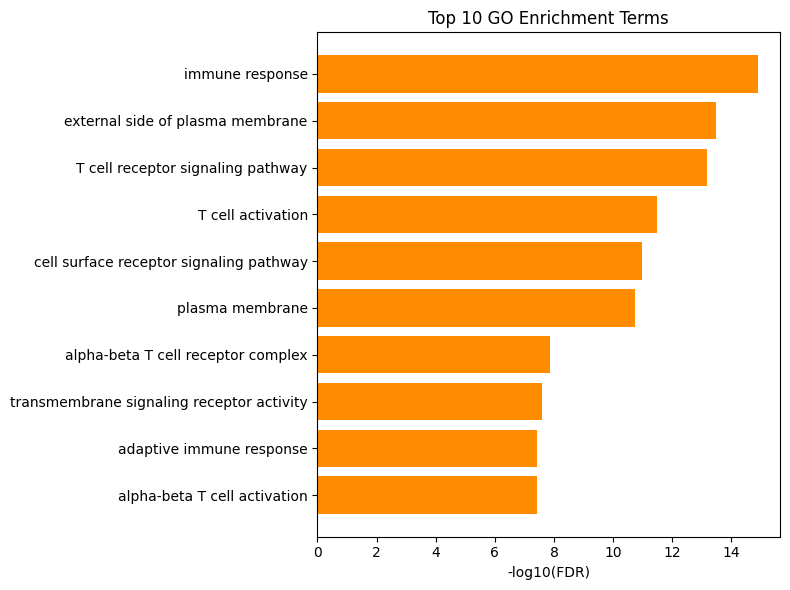

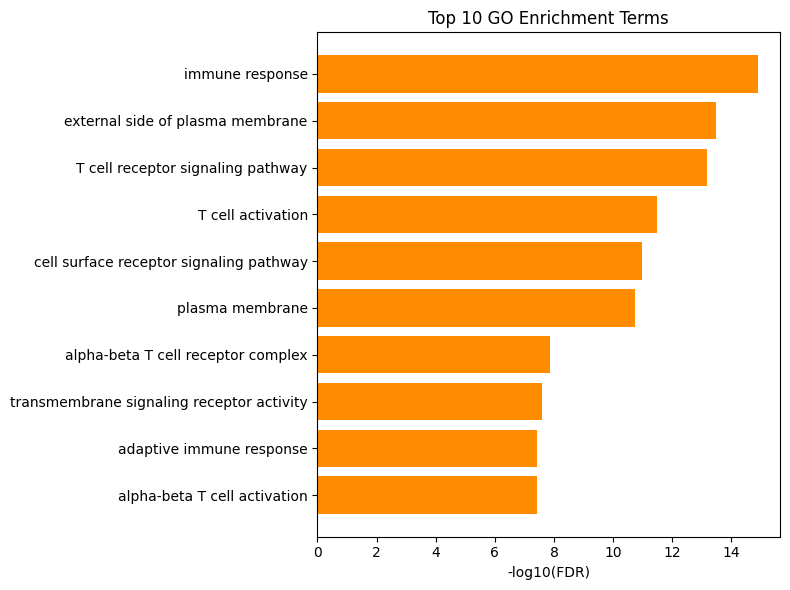

In [12]:
coexpr.plot_go_enrichment(n=10)

## 9. Cell Type & Tissue Breakdown

See which cell types and tissues are enriched for the query.

In [13]:
coexpr.cell_type_enrichment_to_dataframe()

,cell_type,enrichment_score,mean_positive_fraction,n_positive_metacells,p_value,total_metacells
0,Hematopoietic_Lymphoid (T cell),2.0633,0.024897,4669,0.000000e+00,9884
1,Hematopoietic_Lymphoid (B cell/APC-like),0.6327,0.009224,811,1.184491e-37,4628
2,Hematopoietic_Myeloid (Myeloid/APC),0.4434,0.008379,1496,4.180484e-37,9734
3,Neural_CNS (Proliferating/Progenitor-like),0.3296,0.003523,1476,1.358672e-21,10392
4,Epithelial,0.1926,0.007435,1647,1.108394e-09,12751
5,Hematopoietic_Lymphoid (Plasma cell),0.1748,0.015933,204,3.671699e-02,1599
6,Neural_CNS (Neuron),-0.1597,0.004503,516,9.973726e-01,5100
7,Hematopoietic_Myeloid (Erythroid),-0.4900,0.005015,115,9.999819e-01,1429
8,Mesenchymal_Stromal (Fibroblast),-0.1665,0.004996,1116,9.999941e-01,11082
9,Epithelial (Renal tubular-like),-2.1026,0.002515,6,9.999997e-01,228


In [14]:
coexpr.tissue_breakdown_to_dataframe()

,mean_positive_fraction,n_positive_metacells,tissue,total_metacells
0,0.003054,1559,Single-cellRNA-seqrevealscelltype-specificmole...,3273
1,0.006075,1082,Aspatiallyresolvedsingle-cellgenomicatlasofthe...,8987
2,0.006666,945,HematopoieticImmuneCellAtlas,3439
3,0.002053,722,DopaminergicNeuronDifferentiation,6235
4,0.002382,422,earlyHumanEmbryogenesisAtlas,2926
...,...,...,...,...
222,0.000000,0,humanDentalPulpCells,10
223,0.000000,0,humanUrineCells,13
224,0.000000,0,landscapesOfHumanOvarianAgeing,3
225,0.000000,0,nktpbmcZhou,51


## 10. Lightweight Query (Genes Only)

If you only need the correlated gene list (no UMAP scores, no GO), use
the lightweight endpoint for a faster response.

In [15]:
quick = client.get_coexpression_genes(result.job_id, DATASET_ID)
quick.get_top_genes(5)

['FOXP3', 'CTLA4', 'IL2RA', 'ICOS', 'TIGIT']